In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
import imageio

In [2]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def Rand_gen(pos, ratio = 0.1):
    #ratio = 0.06
    pos = np.random.choice([0, 1], size=(pos.shape[0], pos.shape[1]), p=[1 - ratio, ratio])
    return pos

def Glider(pos):
    j = -1
    pos[1+j, 2+j] = pos[2+j, 3+j] = pos[3+j, 1+j] = pos[3+j, 2+j] = pos[3+j, 3+j] = 1
    return pos

def Beacon(pos):
    j = 1
    pos[1+j, 1+j] = pos[1+j, 2+j] = pos[2+j, 1+j] = pos[2+j, 2+j] = 1
    pos[3+j, 3+j] = pos[3+j, 4+j] = pos[4+j, 3+j] = pos[4+j, 4+j] = 1
    return pos

def Puffer(pos):
    j = 10
    pos[3+j, 1+j] = pos[4+j, 1+j] = pos[5+j, 1+j] = pos[10+j, 1+j] = 1
    pos[2+j, 2+j] = pos[5+j, 2+j] = pos[9+j, 2+j] = pos[10+j, 2+j] = pos[11+j, 2+j] = 1
    pos[2+j, 2+j] = pos[5+j, 3+j] = pos[9+j, 3+j] = pos[11+j, 3+j] = pos[12+j, 3+j] = 1
    pos[16+j, 3+j] = pos[17+j, 3+j] = pos[18+j, 3+j] = 1
    pos[1+j, 4+j] = pos[5+j, 4+j] = pos[10+j, 4+j] = pos[11+j, 4+j] = pos[12+j, 4+j] = 1
    pos[10+j, 4+j] = pos[15+j, 4+j] = pos[18+j, 4+j] = 1
    pos[5+j, 5+j] = pos[10+j, 5+j] = pos[11+j, 5+j] = pos[18+j, 5+j] = 1
    pos[1+j, 6+j] = pos[4+j, 6+j] = pos[10+j, 6+j] = pos[14+j, 6+j] = pos[18+j, 6+j] =1
    
    pos[13+j, 7+j] = pos[18+j, 7+j] = pos[18+j, 8+j] = pos[15+j, 9+j] = pos[17+j, 9+j] = 1
    
    return pos

def Gosper(pos):
    j = 1
    pos[6+j, 2+j] = pos[6+j, 3+j] = pos[7+j, 2+j] = pos[7+j, 3+j]  = 1
    pos[4+j, 36+j] = pos[4+j, 37+j] = pos[5+j, 36+j] = pos[5+j, 37+j]  = 1
    
    pos[6+j, 12+j] = pos[7+j, 12+j] = pos[8+j, 12+j] = 1
    pos[5+j, 13+j] = pos[4+j, 14+j] = pos[9+j, 13+j] = pos[10+j, 14+j] = 1
    pos[4+j, 15+j] = pos[10+j, 15+j] = 1
    pos[7+j, 16+j] = pos[5+j, 17+j] = pos[9+j, 17+j] = 1
    pos[7+j, 18+j] = pos[6+j, 18+j] = pos[8+j, 18+j] = pos[7+j, 19+j] = 1
    
    pos[6+j, 22+j] = pos[5+j, 22+j] = pos[4+j, 22+j] = 1
    pos[6+j, 23+j] = pos[5+j, 23+j] = pos[4+j, 23+j] = 1
    pos[7+j, 24+j] = pos[3+j, 24+j] = 1
    pos[7+j, 26+j] = pos[3+j, 26+j] = pos[8+j, 26+j] = pos[2+j, 26+j] = 1
    
    
    return pos

def neighbors_alive(pos, i, j): # Pretty easy intuitive model for all 8 black neigbours
    n = 0
    
    if pos[(i - 1) % pos.shape[0], j] == 1: # left
        n+=1
    if pos[i, (j - 1) % pos.shape[1]] == 1: # down
        n+=1
    if pos[(i - 1) % pos.shape[0], (j - 1) % pos.shape[1]] == 1: # down-left
        n+=1
    if pos[(i - 1) % pos.shape[0], (j + 1) % pos.shape[1]] == 1: # up-left
        n+=1

    if pos[i, (j + 1) % pos.shape[1]] == 1: # up
        n+=1
    if pos[(i + 1) % pos.shape[0], j] == 1: # right
        n+=1
    if pos[(i + 1) % pos.shape[0], (j - 1) % pos.shape[1]] == 1: # down-right
        n+=1
    if pos[(i + 1) % pos.shape[0], (j + 1) % pos.shape[1]] == 1: # up-right
        n+=1
        
    return n


def unhappy_agents(pos):
    a_i_r = []
    a_j_r = []
    a_i_k = []
    a_j_k = []
    for i in range(pos.shape[0]):
        for j in range(pos.shape[1]):
            N_alive = neighbors_alive(pos, i, j)
            
            if pos[i, j] == 0:
                if N_alive == 3:
                    #print('Dead cell:' ,i, j, '; N_neigb =', N_alive, ' - Resurrect')
                    a_i_r.append(i)
                    a_j_r.append(j)
            else:
                if N_alive < 2 or N_alive > 3 :
                    #print('Alive cell:' ,i, j, '; N_neigb =', N_alive, ' - Kill')
                    a_i_k.append(i)
                    a_j_k.append(j)  
                
    return a_i_r, a_j_r, a_i_k, a_j_k



In [3]:
N = 50
Range = 100 # How many rounds do we have
k = 0
ratio = 0.2

pos = np.zeros((N, N))

#pos = Rand_gen(pos, ratio)
#pos = Beacon(pos)
pos = Glider(pos)
#pos = Gosper(pos)
#pos = Puffer(pos)

pos_array = []
alive_history = []
pos_array.append(pos.copy())

I'm process 0 ; Starting point: 0 , Ending point: 49


FileNotFoundError: [Errno 2] No such file or directory: './pics_for_game/1.jpg'

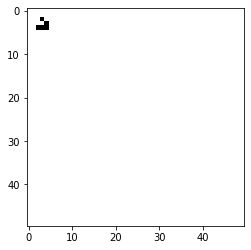

In [12]:
if rank == 0:
    
    frames_path = "./figure/{i}.jpg"
    im = plt.imshow(pos, cmap='binary')
    plt.savefig(frames_path.format(i=0))
    plt.close()
    gif_path = "./game_of_life.gif"

N_ = int(np.floor(N/size))
if N >= size:
    if rank != size - 1:
        N_start = N_*rank
        N_end = N_*(rank + 1) - 1
    else:
        N_start = N_*rank
        N_end = N_start + int(N - N_*(size - 1)) - 1
else:
    if rank < disc:
        N_start = rank
        N_end = rank
    else:
        N_start = 0
        N_end = 0
        
print("I'm process", rank, "; Starting point:", N_start, ', Ending point:', N_end)
for p in range(Range):
    
    start = MPI.Wtime()

    alive_history.append(sum(pos[pos != 0]))
    
    array_i_r, array_j_r, array_i_k, array_j_k = unhappy_agents(pos)

    for i in range(len(array_i_r)):
        pos[array_i_r[i], array_j_r[i]] = 1
    for i in range(len(array_i_k)):
        pos[array_i_k[i], array_j_k[i]] = 0
    pos_array.append(pos.copy())
    
    
    end = MPI.Wtime()
    
    comm.Barrier()
    pos_array = comm.gather(pos_array, 0)
    
    if rank == 0:
        new_pos_array = np.hstack([pos_array[i] for i in range(len(pos_array))])
        im = plt.imshow(new_pos_array[i], cmap='binary')
        plt.savefig(frames_path.format(i = p + 1))
        plt.close()
        pos = new_pos_array.copy()
        
    comm.Barrier()
    comm.Bcast(pos, root=0)
    
if rank == 0:
    print(size, end - start)

In [8]:
if rank == 0:
    filenames = []
    for i in range(Range):
        filenames.append(frames_path.format(i=i))

    images = list(map(lambda filename: imageio.imread(filename), filenames))
    imageio.mimsave(gif_path, images, duration = 0.5)

NameError: name 'max_iter' is not defined